In [28]:
"""
Author: jhzhu
Date: 2024/7/10
Description:
"""
import jieba
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from deep_learning.practice.SimpleRNN import SimpleRNN


def get_vocabulary_list(msgs):
    vocab_set = set()
    for i in msgs:
        vocab_set |= set(i)
        # vocab_set |= set(i) - stopwords_set
    vocab_set.add('<UNK>')
    vocab_set.add('<PAD>')
    return sorted(list(vocab_set))


# every row is a message vector
def messages_2_vectors(vocab_list, msgs, max_len=300):
    msgs_marix = []
    for msg in msgs:
        msg_vector = [vocab_list.index(m) if m in vocab_list else unk_index for m in msg]
        if len(msg) < max_len:
            msg_vector.extend([pad_index] * (max_len - len(msg)))
        msgs_marix.append(msg_vector)
    return msgs_marix


class TakeAwayDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) and isinstance(y, pd.Series):
            self.X = X.reset_index(drop=True)
            self.y = y.reset_index(drop=True)
        else:
            raise ValueError("X must be a pandas DataFrame and y must be a pandas Series")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        if item >= len(self.X):
            raise IndexError(f"Item index {item} is out of bounds")
        x = self.X.iloc[item]
        y = self.y.iloc[item]
        x = torch.tensor(data=x, dtype=torch.long)
        y = torch.tensor(data=[y], dtype=torch.float32)
        return x, y


emotion_file = '../../dataset/中文外卖评论数据集.csv'
take_away_df = pd.read_csv(emotion_file)
take_away_df['words'] = take_away_df['review'].apply(lambda x: jieba.lcut(x.replace(' ', ''), cut_all=False))
vocabulary_list = get_vocabulary_list(take_away_df['words'])
max_msg_len = take_away_df['words'].str.len().max()
pad_index = vocabulary_list.index('<PAD>')
unk_index = vocabulary_list.index('<UNK>')
take_away_vecs = messages_2_vectors(vocabulary_list, take_away_df['words'], max_msg_len)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(take_away_vecs), take_away_df.loc[:, 'label'], test_size=0.3,
                                                    random_state=42, shuffle=True)

take_away_dataset = TakeAwayDataset(X_train, y_train)
take_away_train_dataloader = DataLoader(dataset=take_away_dataset, batch_size=64, shuffle=True)
test_dataset = TakeAwayDataset(X_test, y_test)
take_away_test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [27]:
customized_model = SimpleRNN(dict_len=11010, embedding_dim=300, n_classes=1, pad_index=pad_index)
epochs = 100
learning_rate = 1e-2  # gradient explosion, need preprocess data, then lower the lr
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=customized_model.parameters(), lr=learning_rate)


def get_loss(dataloader):
    customized_model.eval()  # define the model the evaluate module(latchNorm, layerNorm, Dropout)????
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            y_pred = customized_model(x)
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())
    final_loss = round(sum(losses) / len(losses), 5)
    return final_loss


train_losses = []
test_losses = []
for epoch in range(epochs):
    customized_model.train()
    for x, y in take_away_train_dataloader:
        y_pred = customized_model(x)
        loss = loss_fun(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = get_loss(take_away_train_dataloader)
    test_loss = get_loss(take_away_test_dataloader)  # test not need train
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print('Epoch: %s: train loss: %s, test loss: %s' % (epoch, train_loss, test_loss))

torch.save(obj=customized_model.state_dict(), f="./take_away.pt")

Epoch: 0: train loss: 0.0, test loss: 0.0
Epoch: 1: train loss: 0.0, test loss: 0.0
Epoch: 2: train loss: 0.0, test loss: 0.0
Epoch: 3: train loss: 0.0, test loss: 0.0
Epoch: 4: train loss: 0.0, test loss: 0.0
Epoch: 5: train loss: 0.0, test loss: 0.0
Epoch: 6: train loss: 0.0, test loss: 0.0
Epoch: 7: train loss: 0.0, test loss: 0.0
Epoch: 8: train loss: 0.0, test loss: 0.0
Epoch: 9: train loss: 0.0, test loss: 0.0
Epoch: 10: train loss: 0.0, test loss: 0.0
Epoch: 11: train loss: 0.0, test loss: 0.0
Epoch: 12: train loss: 0.0, test loss: 0.0
Epoch: 13: train loss: 0.0, test loss: 0.0
Epoch: 14: train loss: 0.0, test loss: 0.0
Epoch: 15: train loss: 0.0, test loss: 0.0
Epoch: 16: train loss: 0.0, test loss: 0.0
Epoch: 17: train loss: 0.0, test loss: 0.0
Epoch: 18: train loss: 0.0, test loss: 0.0
Epoch: 19: train loss: 0.0, test loss: 0.0
Epoch: 20: train loss: 0.0, test loss: 0.0
Epoch: 21: train loss: 0.0, test loss: 0.0
Epoch: 22: train loss: 0.0, test loss: 0.0
Epoch: 23: train loss

KeyboardInterrupt: 

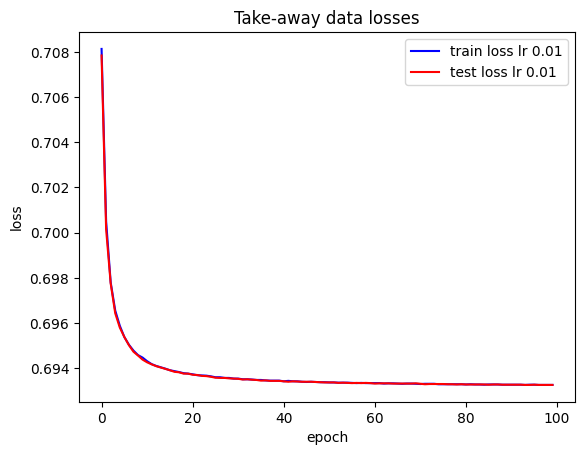

In [22]:
plt.plot(train_losses, label=f'train loss lr {learning_rate}', c='blue')
plt.plot(test_losses, label=f'test loss lr {learning_rate}', c='red')
plt.title('Take-away data losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
model = SimpleRNN(dict_len=11010, embedding_dim=300, n_classes=1)
model.load_state_dict(state_dict=torch.load(f=f"./take_away.pt"),
                      strict=False)
model.eval()
# test on other review
X_test_review = ['卖家态度挺好，只是这蛋糕，我及其不满意，本来女儿过生日，我不在挺愧疚的，订了个蛋糕送她，可是亲戚朋友品尝蛋糕时，所谓的彩虹蛋糕，色素弄在手上洗都洗不掉，这还敢吃麽？结果大家也都是象征性的舔了一下，还感觉味道怪怪的！全部扔掉～唉，女儿也不高兴了，我心里更是愧疚的要命！卖家拜你所赐，绝对没有下一次了！', '口感不错，但送得太慢了', '不太好吃', '味道很好']
result_dict = {0: '差评', 1: '好评'}
X_test_seg = [jieba.lcut(x, cut_all=False) for x in X_test_review]
X_test_vectors = messages_2_vectors(vocabulary_list, X_test_seg, max_msg_len)
print(X_test_vectors)

[[2544, 4957, 5476, 3933, 10999, 2799, 9741, 8965, 10999, 5143, 2665, 759, 7011, 10999, 6158, 3912, 9674, 10999, 5143, 759, 3400, 5476, 5093, 7644, 10999, 9150, 1241, 1093, 8965, 9886, 3930, 10999, 2835, 1333, 3156, 8965, 5896, 10999, 5210, 7644, 4771, 8965, 10999, 8738, 4720, 3400, 5216, 6843, 10058, 6844, 10999, 9741, 9690, 5749, 2862, 10926, 11004, 8317, 3656, 1211, 10058, 5954, 9345, 7644, 8730, 1241, 384, 10999, 9690, 5088, 3088, 4982, 10995, 1818, 5278, 11007, 3206, 10999, 3912, 1211, 759, 10798, 1241, 10999, 5143, 4882, 6015, 5093, 7644, 9101, 10995, 2544, 5396, 1571, 5204, 9406, 10999, 8340, 6691, 719, 516, 1241, 10995, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,

In [17]:
for test_vector in X_test_vectors:
    test_tensor = torch.tensor(data=test_vector, dtype=torch.long).unsqueeze(0)
    y_pred = model(test_tensor).item()
    print(y_pred)
    print(result_dict[round(y_pred)])

0.002977455034852028
差评
0.002977455034852028
差评
0.002977455034852028
差评
0.002977455034852028
差评
